# Unsupervised learning

## Libraries

In [223]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import metrics, decomposition
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

## Parameters

In [3]:
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

RANDOM_STATE = 17

In [42]:
FILE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
FILE_NAME = "UCI HAR Dataset.zip"
DATA_PATH = "../../data/"
TEMP_FOLDER = 'temp'
PATH_TO_SAMSUNG_DATA = Path(os.path.join(DATA_PATH, TEMP_FOLDER, FILE_NAME.strip('.zip')))

## Methods

In [35]:
def load_har_dataset(url, download_path: str, temp_folder: str, filename: str, overwrite=False):
    import os
    from pathlib import Path
    from zipfile import ZipFile
    
    # check if existed already
    extract_path = Path(os.path.join(download_path, temp_folder))
    filepath = Path(os.path.join(download_path, filename))
    
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
    else:
        print("Downloading the dataset from:  ", url)
        response = requests.get(url)

        with open(filepath, 'wb') as f:
            f.write(response.content)

    # Extract all the contents of zip file in current directory
    with ZipFile(filepath, 'r') as zipObj:
        zipObj.extractall(extract_path)

In [88]:
def get_pca_components(X, target_variance=0.9, random_state=RANDOM_STATE):
    
    pca = PCA(random_state=RANDOM_STATE).fit(X)
    a = np.cumsum(pca.explained_variance_ratio_)
    return np.argmax(a >= target_variance) + 1

In [ ]:
def recall_per_class(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    recall_scores = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives

        recall_scores[i] = true_positives / (true_positives + false_negatives)

    return recall_scores

In [ ]:
def precision_per_class(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision_scores = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives

        precision_scores[i] = true_positives / (true_positives + false_positives)

    return precision_scores

In [ ]:
precision_recall_auc_per_class(confusion_matrix, y_scores):
    
    num_classes = confusion_matrix.shape[0]
    precision_auc_scores = np.zeros(num_classes)

    # Binarize the output scores (convert multiclass to binary)
    Y = label_binarize(np.arange(num_classes), classes=np.arange(num_classes))
    
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], y_scores[:, i])
        precision_auc_scores[i] = auc(recall, precision)

    return precision_auc_scores

## Reading data

In [36]:
load_har_dataset(url=FILE_URL, download_path=DATA_PATH, temp_folder='temp', filename=FILE_NAME)

In [40]:
X_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "X_train.txt")
y_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "y_train.txt").astype(int)

X_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "X_test.txt")
y_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "y_test.txt").astype(int)

In [47]:
X_train.shape

(7352, 561)

In [43]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

For clustering, we do not need a target vector, so we’ll work with the combination of training and test samples. Merge `X_train` with `X_test`, and `y_train` with `y_test`.

In [48]:
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train,y_test], axis=0)

Define the number of unique values of the labels of the target class.

In [49]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [50]:
n_classes = np.unique(y).size
n_classes

6

[These labels correspond to](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names):

1. walking
2. walking upstairs
3. walking downstairs
4. sitting
5. standing
6. laying down

Scale the sample using `StandardScaler` with default parameters.

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix `random_state` (`RANDOM_STATE` constant).

In [98]:
n_components = get_pca_components(X_scaled, target_variance=0.9, random_state=RANDOM_STATE)

pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

### Question 1

What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [99]:
X_pca.shape[1]

65

### Question 2

What percentage of the variance is covered by the first principal component? Round to the nearest percent.

In [96]:
pca = PCA(random_state=RANDOM_STATE).fit(X_scaled)
np.round(np.cumsum(pca.explained_variance_ratio_)[0] * 100)

51.0

Visualize data in projection on the first two principal components.

Projecting 561-dimensional data to 2D


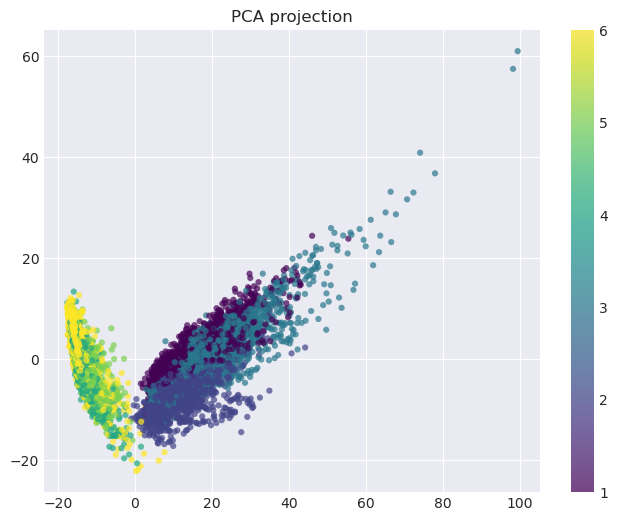

In [129]:
print("Projecting %d-dimensional data to 2D" % X.shape[1])

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,
    edgecolor="none",
    alpha=0.7,
    s=20,
    cmap="viridis",
)
plt.colorbar()
plt.title("PCA projection");

### Question 3

If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters?

- 2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying).

____

Perform clustering with the `KMeans` method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

- `n_clusters` = `n_classes` (number of unique labels of the target class)
- `n_init` = 100
- `random_state` = `RANDOM_STATE` (for reproducibility of the result)

Other parameters should have default values.

In [130]:
kmeans = KMeans(n_clusters=n_classes, random_state=RANDOM_STATE, n_init=100)
X_kmeans = kmeans.fit_transform(X_scaled)

Projecting 561-dimensional data to 2D


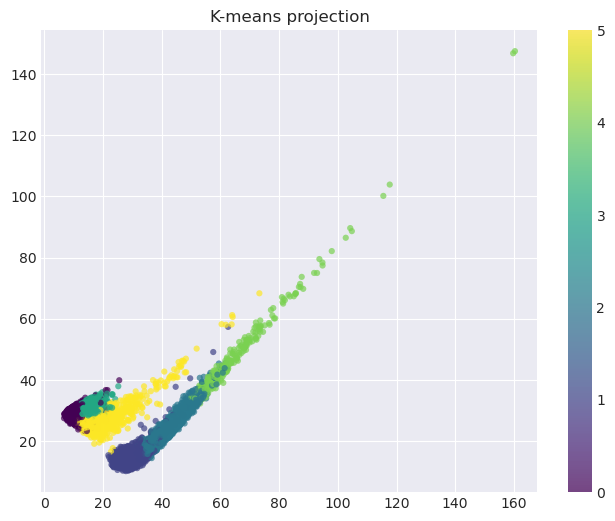

In [140]:
cluster_labels = kmeans.labels_

print("Projecting %d-dimensional data to 2D" % X.shape[1])

plt.figure(figsize=(8, 6))
plt.scatter(
    X_kmeans[:, 0],
    X_kmeans[:, 1],
    c=cluster_labels,
    edgecolor="none",
    alpha=0.7,
    s=20,
    cmap="viridis",
)
plt.colorbar()
plt.title("K-means projection");

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the KMeans algorithm is confused at.

In [141]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs', 'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,903,742,0,77,0,1722
going up the stairs,0,1242,295,0,5,2,1544
going down the stairs,0,321,889,0,196,0,1406
sitting,1234,1,0,91,0,451,1777
standing,1340,0,0,0,0,566,1906
laying,53,5,0,1556,0,330,1944
all,2627,2472,1926,1647,278,1349,10299


We see that for each class (i.e., each activity) there are several clusters. Let’s look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.

Example: if for class “walking downstairs” (with 1406 instances belonging to it), the distribution of clusters is:

- cluster 1 - 900
- cluster 3 - 500
- cluster 6 - 6,

then such a share will be 900/1406 = 0.64.

In [143]:
tab.loc['going down the stairs']

cluster1       0
cluster2     321
cluster3     889
cluster4       0
cluster5     196
cluster6       0
all         1406
Name: going down the stairs, dtype: int64

### Question 4

Which activity is separated from the rest better than others based on the simple metric described above?

In [146]:
tab.iloc[:-1,:-1]

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
walking,0,903,742,0,77,0
going up the stairs,0,1242,295,0,5,2
going down the stairs,0,321,889,0,196,0
sitting,1234,1,0,91,0,451
standing,1340,0,0,0,0,566
laying,53,5,0,1556,0,330


In [171]:
pd.Series(tab.iloc[:-1,:-1].max(axis=1) / tab.iloc[:-1,-1]).sort_values(ascending=False)

going up the stairs      0.804404
laying                   0.800412
standing                 0.703043
sitting                  0.694429
going down the stairs    0.632290
walking                  0.524390
dtype: float64

- all three options are incorrect

It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only n_clusters.

In [173]:
inertia = []

for k in range(1, n_classes + 1):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=100).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

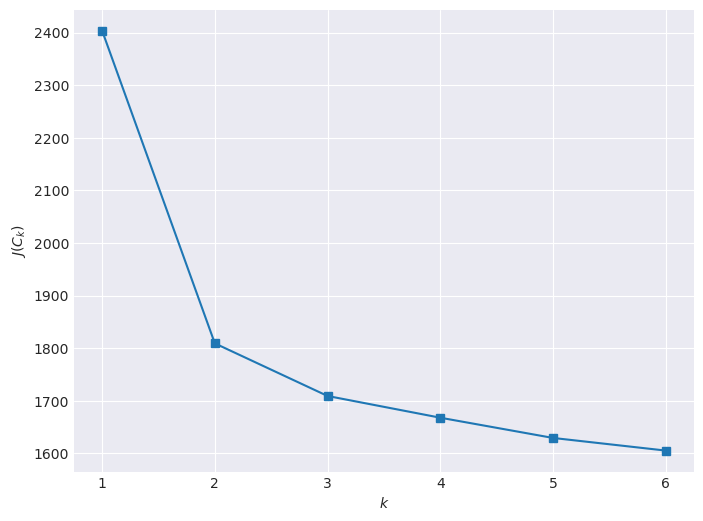

In [177]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_classes + 1), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$");

We calculate  $D(k)$, as described in [this article](https://www.kaggle.com/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering) in the section "Selecting the number of clusters for kMeans".

In [187]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[(inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])] = k

d

{0.168162961448523: 2,
 0.41307462109843923: 3,
 0.9312070113461219: 4,
 0.6248592966608618: 5}

### Question 5

How many clusters can we choose according to the elbow method?

In [193]:
d[min(d.keys())]

2

___
Let’s try another clustering algorithm, described in the article – agglomerative clustering.

In [210]:
ag = AgglomerativeClustering(
    n_clusters=n_classes,
    linkage='ward'
).fit(X_pca)

Calculate the Adjusted Rand Index (`sklearn.metrics`) for the resulting clustering and for KMeans with the parameters from the 4th question.

In [211]:
print('KMeans: ARI =', metrics.adjusted_rand_score(y, cluster_labels))
print('Agglomerative CLustering: ARI =', metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.419224271062724
Agglomerative CLustering: ARI = 0.49362763373004886


### Question 6

Select all the correct statements.

Answer options:
- [x] According to ARI, KMeans handled clustering worse than Agglomerative Clustering.
    - Higher ARI better
- [x] For ARI, it does not matter which tags are assigned to the cluster, only the partitioning of instances into clusters matters.
    - If the clusters are renumbered it does not change the ARI.
- [x] In case of random partitioning into clusters, ARI will be close to zero.
    - True.

You can notice that the task is not very well solved when we try to detect several clusters (> 2). Now, let’s solve the classification problem, given that the data is labeled.

For classification, use the support vector machine – class `sklearn.svm.LinearSVC`. In this course, we didn’t study this algorithm separately, but it is well-known and you can read about it, for example [here](http://cs231n.github.io/linear-classify/#svmvssoftmax).

Choose the `C` hyperparameter for `LinearSVC` using `GridSearchCV`.

- Train the new `StandardScaler` on the training set (with all original features), apply scaling to the test set;
- In `GridSearchCV`, specify `cv = 3`.

In [315]:
# Create a pipeline with StandardScaler and LinearSVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler
    ('clf', LinearSVC(max_iter=10000, random_state=RANDOM_STATE))          # LinearSVC
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10]  # C values to search
}

# Create and Kfold
cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

# Initialize GridSearchCV
best_svc = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    #scoring='adjusted_rand_score',
    #n_jobs=-1,
    verbose=10,
)

best_svc.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START clf__C=0.001................................................
[CV 1/3; 1/5] END .................clf__C=0.001;, score=0.935 total time=   4.9s
[CV 2/3; 1/5] START clf__C=0.001................................................
[CV 2/3; 1/5] END .................clf__C=0.001;, score=0.896 total time=   4.5s
[CV 3/3; 1/5] START clf__C=0.001................................................
[CV 3/3; 1/5] END .................clf__C=0.001;, score=0.944 total time=   4.6s
[CV 1/3; 2/5] START clf__C=0.01.................................................
[CV 1/3; 2/5] END ..................clf__C=0.01;, score=0.942 total time=   4.1s
[CV 2/3; 2/5] START clf__C=0.01.................................................
[CV 2/3; 2/5] END ..................clf__C=0.01;, score=0.916 total time=   3.8s
[CV 3/3; 2/5] START clf__C=0.01.................................................
[CV 3/3; 2/5] END ..................clf__C=0.01;,

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LinearSVC(max_iter=10000,
                                                  random_state=17))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10]}, verbose=10)

In [316]:
best_svc.best_params_, best_svc.best_score_

({'clf__C': 0.1}, 0.9390667144050603)

In [317]:
# Evaluate the model on the test set
test_ari = best_svc.score(X_test, y_test)
print(f"ARI: {test_ari:.4f}")

ARI: 0.9620


### Question 7

Which value of the hyperparameter C was chosen the best on the basis of cross-validation?

Answer options:

- [ ] 0.001
- [ ] 0.01
- [x] 0.1
- [ ] 1
- [ ] 10

In [318]:
y_predicted = best_svc.predict(X_test)

In [319]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'lying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'lying', 'all']
tab

,walking,climbing up the stairs,going down the stairs,sitting,standing,lying,all
walking,494,2,0,0,0,0,496
climbing up the stairs,12,459,0,0,0,0,471
going down the stairs,2,4,413,1,0,0,420
sitting,0,4,0,426,61,0,491
standing,0,0,0,15,517,0,532
lying,0,0,0,0,11,526,537
all,508,469,413,442,589,526,2947


### Question 8

Which activity type is worst detected by SVM in terms of precision? Recall?

- precision – standing, recall – sitting

In [320]:
class_labels = ['walking', 'climbing up the stairs', 'going down the stairs', 'sitting', 'standing', 'lying']
confusion_matrix = confusion_matrix = tab.iloc[:-1:,:-1:].values

In [321]:
precision_per_class(confusion_matrix)
precisions = precision_per_class(confusion_matrix)
recalls = recall_per_class(confusion_matrix)
  
pr_tab = pd.DataFrame(
    {
        'labels' : class_labels,
        'precision': precisions,
        'recall': recalls
    }
).set_index('labels')

pr_tab

,precision,recall
labels,,
walking,0.972441,0.995968
climbing up the stairs,0.978678,0.974522
going down the stairs,1.000000,0.983333
sitting,0.963801,0.867617
standing,0.877759,0.971805
lying,1.000000,0.979516


Finally, do the same thing as in Question 7, but add PCA.

Use `X_train_scaled` and `X_test_scaled`

- Train the same PCA as before, on the scaled training set, apply scaling to the test set
- Choose the hyperparameter `C` via cross-validation on the training set with PCA-transformation. You will notice how much faster it works now.

In [322]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [329]:

# Create a pipeline with StandardScaler and LinearSVC
pipeline = Pipeline([
    #('scaler', StandardScaler()),  # StandardScaler
    ('clf', LinearSVC(max_iter=10000, random_state=RANDOM_STATE))          # LinearSVC
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10]  # C values to search
}

# Create and Kfold
cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

# Initialize GridSearchCV
best_svc_pca = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    #scoring='adjusted_rand_score',
    #n_jobs=-1,
    verbose=10,
)

best_svc_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START clf__C=0.001................................................
[CV 1/3; 1/5] END .................clf__C=0.001;, score=0.889 total time=   0.5s
[CV 2/3; 1/5] START clf__C=0.001................................................
[CV 2/3; 1/5] END .................clf__C=0.001;, score=0.857 total time=   0.4s
[CV 3/3; 1/5] START clf__C=0.001................................................
[CV 3/3; 1/5] END .................clf__C=0.001;, score=0.896 total time=   0.4s
[CV 1/3; 2/5] START clf__C=0.01.................................................
[CV 1/3; 2/5] END ..................clf__C=0.01;, score=0.890 total time=   0.4s
[CV 2/3; 2/5] START clf__C=0.01.................................................
[CV 2/3; 2/5] END ..................clf__C=0.01;, score=0.868 total time=   0.3s
[CV 3/3; 2/5] START clf__C=0.01.................................................
[CV 3/3; 2/5] END ..................clf__C=0.01;,

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('clf',
                                        LinearSVC(max_iter=10000,
                                                  random_state=17))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10]}, verbose=10)

In [330]:
grid_search.best_params_, grid_search.best_score_

({'clf__C': 1}, 0.8874858273295886)

### Question 9

What is the difference between the best quality (accuracy) for cross-validation in the case of all 561 initial characteristics and in the second case, when the principal component method was applied? Round to the nearest percent.

In [331]:
print(f'{round(100 * (best_svc_pca.best_score_ - best_svc.best_score_))} %')

-4 %


### Question 10

Select all the correct statements:

Answer options:

- [ ] Principal component analysis in this case allowed to reduce the model training time, while the quality (mean cross-validation accuracy) suffered greatly, by more than 10%;
- [x] PCA can be used to visualize data, but there are better methods for this task, for example, tSNE. However, PCA has lower computational complexity;
- [x] PCA builds linear combinations of initial features, and in some applications they might be poorly interpreted by humans.